In [1]:
%pip install huggingface_hub httpx tqdm --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00


In [27]:
import httpx
from huggingface_hub import list_models, ModelFilter, hf_hub_url
import pandas as pd
from tqdm.contrib.concurrent import thread_map
from huggingface_hub import model_info
from tqdm.auto import tqdm

In [3]:
peft_models = list(iter(list_models(filter=ModelFilter(library="peft"), full=True)))
len(peft_models)

6981

In [4]:
peft_models[0].siblings[2]

RepoFile: {'blob_id': None, 'lfs': None, 'rfilename': 'adapter_config.json', 'size': None}

In [5]:
httpx.get(hf_hub_url(peft_models[0].modelId,'adapter_config.json')).json()

{'base_model_name_or_path': 'facebook/opt-350m',
 'bias': 'none',
 'enable_lora': None,
 'fan_in_fan_out': False,
 'inference_mode': True,
 'lora_alpha': 32,
 'lora_dropout': 0.05,
 'merge_weights': False,
 'peft_type': 'LORA',
 'r': 16,
 'target_modules': ['q_proj', 'v_proj'],
 'task_type': 'SEQ_CLS'}

In [6]:
httpx.get(hf_hub_url(peft_models[0].modelId,'adapter_config.json')).json().get('base_model_name_or_path')

'facebook/opt-350m'

In [7]:
def try_get_base_model(model):
    model_id = model.modelId
    downloads = model.downloads
    author = model.author
    try:
        return model_id, httpx.get(hf_hub_url(model_id,'adapter_config.json')).json().get('base_model_name_or_path'), downloads, author
    except Exception:
        return None

In [9]:
results = thread_map(try_get_base_model, peft_models)

  0%|          | 0/6981 [00:00<?, ?it/s]

In [11]:
df = pd.DataFrame(results, columns=['model_id','base_model','downloads','author']).dropna().sort_values('downloads',ascending=False)
df

model_id  \
562                             aarnphm/opt-6-7b-quotes   
914                   artek0chumak/bloom-560m-safe-peft   
1061     peft-internal-testing/tiny-OPTForCausalLM-lora   
1065     peft-internal-testing/tiny_T5ForSeq2SeqLM-lora   
1063  peft-internal-testing/tiny_OPTForQuestionAnswe...   
...                                                 ...   
2569  KingKazma/cnn_dailymail_gpt2_p_tuning_500_10_3...   
2567  KingKazma/cnn_dailymail_gpt2_p_tuning_500_10_3...   
2566  KingKazma/cnn_dailymail_gpt2_p_tuning_500_10_3...   
2565  KingKazma/cnn_dailymail_gpt2_p_tuning_500_10_3...   
6980              AhmedBou/Falcon_7B_Science_Exam_QLoRA   

                                             base_model  downloads  \
562   /home/ubuntu/.local/share/bentoml/models/pt-fa...   290304.0   
914                               bigscience/bloom-560m    33069.0   
1061     hf-internal-testing/tiny-random-OPTForCausalLM    17217.0   
1065  trl-internal-testing/tiny-T5ForConditionalGene...    15197.0   
1063     hf-internal-testing/tiny-random-OPTForCausalLM    15182.0   
...                                                 ...        ...   
2569                                               gpt2        0.0   
2567                                               gpt2        0.0   
2566                                               gpt2        0.0   
2565                                               gpt2        0.0   
6980                                   tiiuae/falcon-7b        0.0   

                     author  
562                 aarnphm  
914            artek0chumak  
1061  peft-internal-testing  
1065  peft-internal-testing  
1063  peft-internal-testing  
...                     ...  
2569              KingKazma  
2567              KingKazma  
2566              KingKazma  
2565              KingKazma  
6980               AhmedBou  

[6663 rows x 4 columns]

In [22]:
df['base_model'].value_counts()

gpt2                                 1069
TinyPixel/Llama-2-7B-bf16-sharded     456
t5-small                              344
decapoda-research/llama-7b-hf         239
google/flan-t5-large                  235
                                     ... 
TheBloke/Llama-2-70B-Chat-fp16          1
qqqube/spre4-lora2                      1
qqqube/spre4-nw-lora2                   1
qqqube/spre4-pft4                       1
openai/clip-vit-base-patch32            1
Name: base_model, Length: 470, dtype: int64

<Axes: >

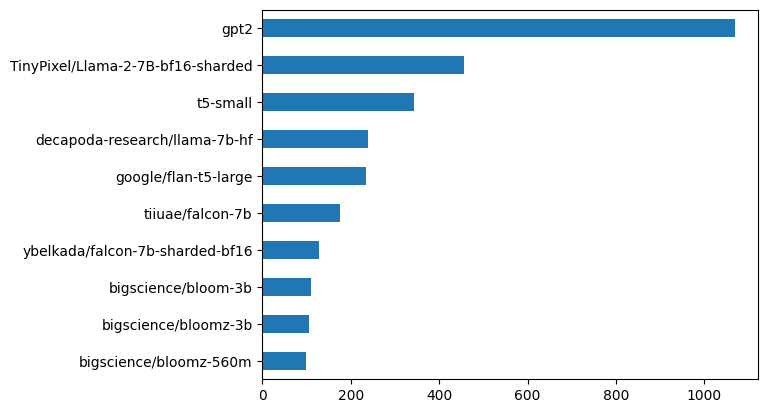

In [25]:
plt = df['base_model'].value_counts().head(10).sort_values(ascending=True).plot(kind='barh')
plt.figure.savefig('top_models.png')
plt

In [26]:
base_models = set(df['base_model'].to_list())

In [28]:
is_valid_hub_id = []
for model in tqdm(base_models):
    try:
        model_info(model)
        is_valid_hub_id.append(model)
    except Exception:
        continue


  0%|          | 0/470 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [17]:
len(is_valid_hub_id)

470

In [18]:
df = df[df.apply(lambda x: x['base_model'] in is_valid_hub_id, axis=1)]

In [19]:
df

model_id  \
914                   artek0chumak/bloom-560m-safe-peft   
1061     peft-internal-testing/tiny-OPTForCausalLM-lora   
1065     peft-internal-testing/tiny_T5ForSeq2SeqLM-lora   
1063  peft-internal-testing/tiny_OPTForQuestionAnswe...   
1066  peft-internal-testing/tiny_OPTForSequenceClass...   
...                                                 ...   
2569  KingKazma/cnn_dailymail_gpt2_p_tuning_500_10_3...   
2567  KingKazma/cnn_dailymail_gpt2_p_tuning_500_10_3...   
2566  KingKazma/cnn_dailymail_gpt2_p_tuning_500_10_3...   
2565  KingKazma/cnn_dailymail_gpt2_p_tuning_500_10_3...   
6980              AhmedBou/Falcon_7B_Science_Exam_QLoRA   

                                             base_model  downloads  \
914                               bigscience/bloom-560m    33069.0   
1061     hf-internal-testing/tiny-random-OPTForCausalLM    17217.0   
1065  trl-internal-testing/tiny-T5ForConditionalGene...    15197.0   
1063     hf-internal-testing/tiny-random-OPTForCausalLM    15182.0   
1066     hf-internal-testing/tiny-random-OPTForCausalLM    15178.0   
...                                                 ...        ...   
2569                                               gpt2        0.0   
2567                                               gpt2        0.0   
2566                                               gpt2        0.0   
2565                                               gpt2        0.0   
6980                                   tiiuae/falcon-7b        0.0   

                     author  
914            artek0chumak  
1061  peft-internal-testing  
1065  peft-internal-testing  
1063  peft-internal-testing  
1066  peft-internal-testing  
...                     ...  
2569              KingKazma  
2567              KingKazma  
2566              KingKazma  
2565              KingKazma  
6980               AhmedBou  

[5570 rows x 4 columns]

<Axes: >

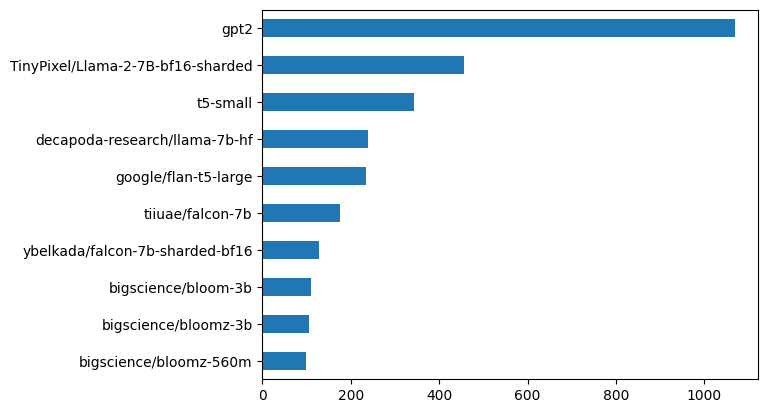

In [20]:
df['base_model'].value_counts().head(10).sort_values(ascending=True).plot(kind='barh')


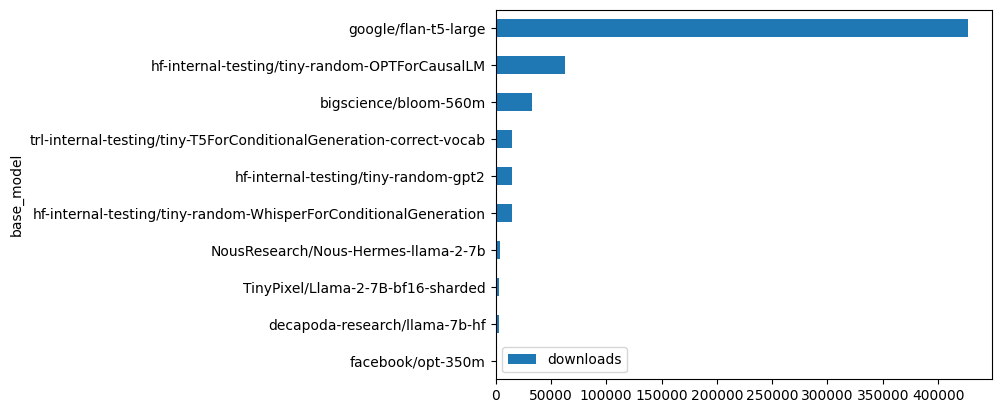

In [39]:
plt = df.groupby('base_model').sum(numeric_only=True).sort_values('downloads',ascending=False).head(10).sort_values('downloads',ascending=True).plot(kind='barh')
plt.figure.savefig('top_model_children_downloads.png')